In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

f = open('data.txt', 'r')

data_x = []
data_y = []

for i, tt in enumerate(f):
    if(i>0):
        tmp = tt.split()
        if(i==1):
            prev = [float(tmp[0]), float(tmp[1])] 
        data_x.append([float(tmp[2]), float(tmp[3]), float(tmp[4]), prev[0], prev[1]])
        data_y.append([float(tmp[0]), float(tmp[1])])
        prev = data_y[-1]         
        

In [2]:
def normalize(t, max_, min_):
    return (t - min_) / (max_ - min_)

train_x = np.array(data_x, dtype=float)
train_y = np.array(data_y, dtype=float) + 0.4
max1, max2, max3, max4, max5 = max(train_x[:, 0]), max(train_x[:, 1]), max(train_x[:, 2]), max(train_x[:, 3]), max(train_x[:, 4])
min1, min2, min3, min4, min5 = min(train_x[:, 0]), min(train_x[:, 1]), min(train_x[:, 2]), min(train_x[:, 3]), min(train_x[:, 4])

train_x[:, 0] = normalize(train_x[:, 0], max1+0.6, min1-0.6)
train_x[:, 1] = normalize(train_x[:, 1], max2+0.6, min2-0.6)
train_x[:, 2] = normalize(train_x[:, 2], max3+0.6, min3-0.6)
train_x[:, 3] = normalize(train_x[:, 3], max4+0.02, min4-0.02)
train_x[:, 4] = normalize(train_x[:, 4], max5+0.02, min5-0.02)

print(max(train_x[:, 0]), max(train_x[:, 1]), max(train_x[:, 2]), max(train_x[:, 3]), max(train_x[:, 4]))
print(min(train_x[:, 0]), min(train_x[:, 1]), min(train_x[:, 2]), min(train_x[:, 3]), min(train_x[:, 4]))

0.885673803352 0.886284509335 0.898647912476 0.893253059634 0.893253059634
0.114326196648 0.113715490665 0.101352087524 0.106746940366 0.106746940366


In [3]:
m = 10
n = 10
in_dim = train_x.shape[1]
out_dim = train_y.shape[1]
init_sigma = 1
lr_w = 1
lr_A = 1
lr_y = 1
neurons_location = []
for i in range(m):
    for j in range(n):
        neurons_location.append([i, j])
neurons_location = np.array(neurons_location, dtype='float32')
batch_size = 100
num_neurons = m*n

### Model

In [4]:
# inputs
x = tf.placeholder('float32', [1, in_dim], name='x')
y = tf.placeholder('float32', [out_dim, 1], name='y')
time_constant = tf.placeholder('float32', [1])
location = tf.constant(neurons_location)

# Varibles
global_step = tf.Variable(0.0, trainable=False)
w = tf.Variable(tf.truncated_normal([m*n, in_dim], 0.5, 0.3))
y_neurons = tf.Variable(tf.truncated_normal([m*n, out_dim], 0.0, 1.0))
A_neurons = tf.Variable(tf.truncated_normal([m*n, out_dim, in_dim], 0.0, 1.0))

# distance btw input and neurons
dist = tf.reduce_sum(tf.square(x- w), axis=1)

# winning neuron index
winning_neuron = tf.argmin(dist)

# neighbourhood function 
sigma = init_sigma*tf.exp(-global_step/time_constant)
neighbourhood_func = tf.expand_dims(tf.exp(-tf.reduce_sum(tf.square(location - location[winning_neuron]), axis=1)/(2*tf.square(sigma))), 1)

# sum of neighbourhood function 
s = tf.reduce_sum(neighbourhood_func)

# prediction
y_pred = tf.matmul(tf.transpose(y_neurons + tf.squeeze(tf.matmul(A_neurons, tf.expand_dims(x-w, 2)))), neighbourhood_func)/s

# error
error = y - y_pred
mul = tf.matmul(neighbourhood_func, tf.transpose(error))/s

# update rules
delta_w = lr_w*tf.multiply(x-w, neighbourhood_func)
delta_y = lr_y*mul
delta_A = lr_A*tf.matmul(tf.expand_dims(mul, 2), tf.expand_dims(x-w, 1))

# updating variables
update_w = tf.assign_add(w, delta_w)
update_y = tf.assign_add(y_neurons, delta_y)
update_A = tf.assign_add(A_neurons, delta_A)
update_global_step = tf.assign_add(global_step, 1)
# training operation
train_op = tf.group(update_w, update_y, update_A, update_global_step)

# loss 
loss = tf.reduce_sum(tf.square(error))
saver = tf.train.Saver(tf.global_variables())

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())                          # For initializing all the variables

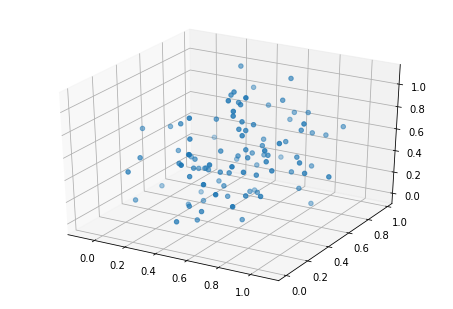

In [5]:
weights = sess.run(w)
fig=pyplot.figure(figsize=(10, 10), dpi= 60, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
ax.set_xlabel('$S_x$', fontsize=20)
ax.set_ylabel('$S_y$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('$S_z$', fontsize=20, rotation=0)
ax.scatter(weights[:, 0], weights[:, 1], weights[:, 2], color='g', label="Initial Neurons")
ax.legend(fontsize=15)
pyplot.show()

In [6]:
epochs = 450
num = len(train_x)
loss_collection = []

for i in range(epochs):
    total_loss = 0
    rand = np.random.randint(0, len(train_x), len(train_x))
    train_xr = train_x[rand]
    train_yr = train_y[rand]
    for j in range(num):
        input_x = np.reshape(train_xr[j], [1, in_dim])
        input_y = np.reshape(train_yr[j], [out_dim, 1])
        _, _loss, step = sess.run([train_op, loss, global_step], feed_dict={x:input_x, y:input_y, time_constant:[100000000]})
        if(_loss == np.nan):
            print(j, _loss)
        total_loss += _loss
    if(i%1==0):
        loss_collection.append(total_loss/num)
        print(i, total_loss/num) 

saver.save(sess, save_path="model_prev1/")                         

0 0.0162748152693
1 0.00397962076217
2 0.00286002185166
3 0.00231659630986
4 0.0021705573198
5 0.0016791797451
6 0.00138609020775
7 0.00152920087681
8 0.00119654716438
9 0.00106810234245
10 0.00102041162506
11 0.000777966068007
12 0.000953420079897
13 0.00111034345835
14 0.000968988031595
15 0.000809421439535
16 0.000815407135223
17 0.000700515789819
18 0.000692103883128
19 0.000580164144231
20 0.000653768316691
21 0.00061007842952
22 0.000530764874651
23 0.000545721120512
24 0.000483251873167
25 0.000529617487781
26 0.000456945820448
27 0.000462144355565
28 0.000463739697336
29 0.000536477841302
30 0.000462105436436
31 0.000705056356424
32 0.000632827412834
33 0.000571533093115
34 0.000426245146742
35 0.000460039044604
36 0.000372423452594
37 0.000353200723654
38 0.000400601054946
39 0.000379785891032
40 0.000509072452111
41 0.000394777516159
42 0.000391662814945
43 0.000469700101838
44 0.000355573314249
45 0.00040281467442
46 0.000386983718452
47 0.000332114522469
48 0.00037457045272

381 0.000102684368325
382 9.77512318931e-05
383 0.000120633919421
384 0.000116971726565
385 0.00015832319309
386 0.000123944389437
387 0.000136224945082
388 0.000108636417387
389 9.73904720425e-05
390 0.00012437524037
391 9.34686490512e-05
392 0.000100114804786
393 0.000122238790074
394 0.000145855941381
395 0.000138248765104
396 0.000133353977234
397 0.000139340587195
398 0.000139159928281
399 0.000141849233205
400 0.000228179714379
401 0.000247720461027
402 0.000223146448214
403 0.000208156678334
404 0.000192232726441
405 0.000180969027169
406 0.000184464695977
407 0.000167643983841
408 0.000168137693909
409 0.000164003803964
410 0.000148826973622
411 0.000161820200879
412 0.000155065019765
413 0.000149428272663
414 0.00014539793371
415 0.000171321607411
416 0.000144434285829
417 0.000144608200013
418 0.000144248075834
419 0.000132418476657
420 0.000117808604667
421 0.000128292944369
422 0.000139275933087
423 0.000188146001475
424 0.000156187777734
425 0.000191097833298
426 0.0001586

'model_prev1/'

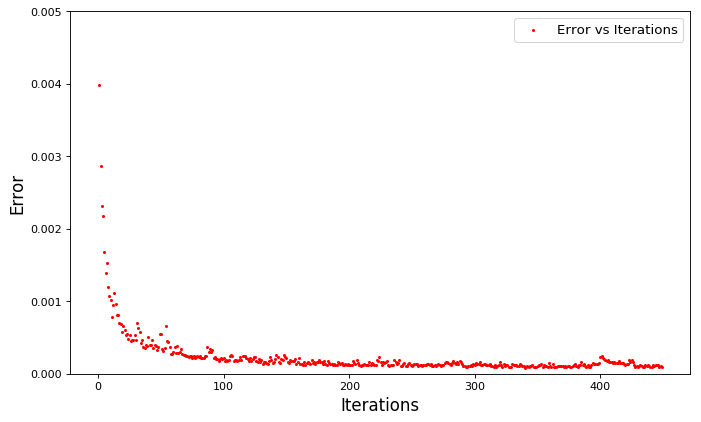

In [27]:
time = [i for i in range(len(loss_collection))]
fig=pyplot.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time, loss_collection,  s=3, color='r', label="Error vs Iterations")
pyplot.ylabel("Error", fontsize=15)
pyplot.xlabel("Iterations", fontsize=15)
pyplot.ylim(0, 5.e-3)
pyplot.legend(fontsize=12, loc='upper right')
pyplot.show()

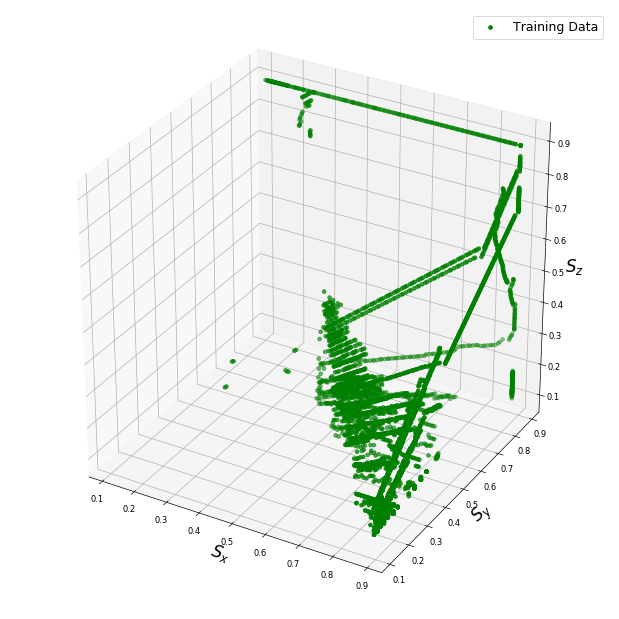

In [14]:
fig=pyplot.figure(figsize=(10, 10), dpi= 60, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
ax.set_xlabel('$S_x$', fontsize=20)
ax.set_ylabel('$S_y$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('$S_z$', fontsize=20, rotation=0)
ax.scatter(train_x[:, 0], train_x[:, 1], train_x[:, 2], color='g', label='Training Data')
ax.legend(fontsize=15)
pyplot.show()

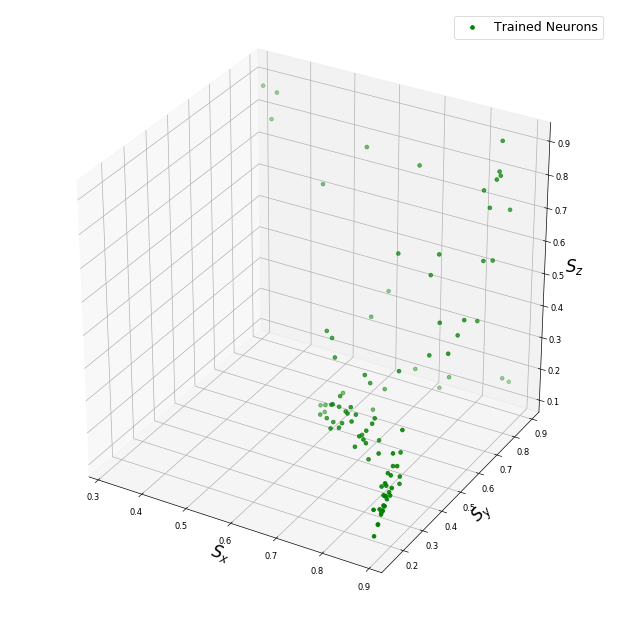

In [13]:
weights = sess.run(w)
fig=pyplot.figure(figsize=(10, 10), dpi= 60, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
ax.set_xlabel('$S_x$', fontsize=20)
ax.set_ylabel('$S_y$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('$S_z$', fontsize=20, rotation=0)
ax.scatter(weights[:, 0], weights[:, 1], weights[:, 2], color='g', label="Trained Neurons")
ax.legend(fontsize=15)
pyplot.show()

In [7]:
num = len(train_x)
pred = []
for j in range(num):
    print(j)
    input_x = np.reshape(train_x[j], [1, in_dim])
    temp_pred = sess.run([tf.squeeze(y_pred)], feed_dict={x:input_x, time_constant:[100000000]})
    pred.append(temp_pred)

pred = np.array(pred)
pred = np.reshape(pred, [num, out_dim])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


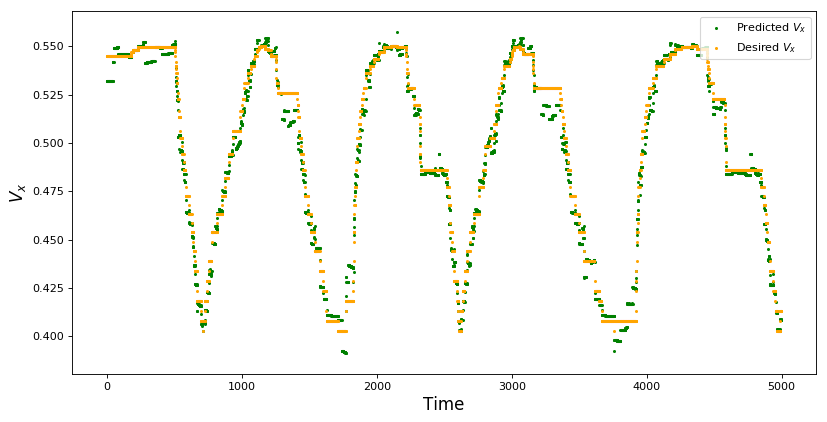

In [10]:
time = [i for i in range(num)]
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time, pred[:, 0], s=3, color='g', label="Predicted $V_x$")
pyplot.scatter(time, train_y[:, 0], s=3, color='orange', label='Desired $V_x$')
pyplot.ylabel("$V_x$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper right')
pyplot.show()

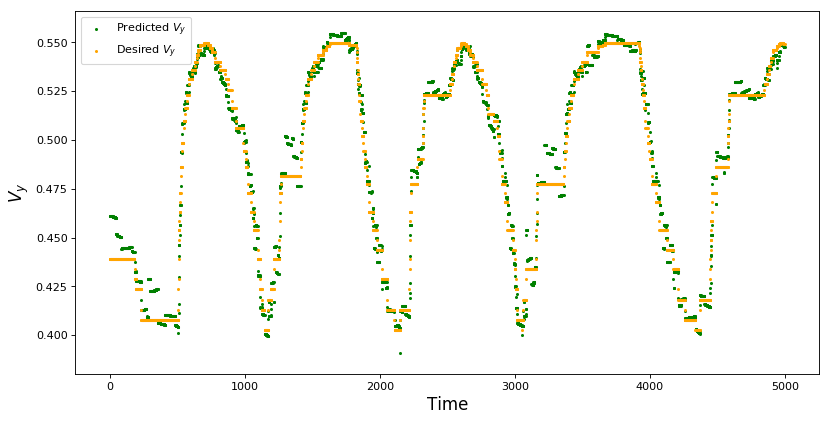

In [11]:
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time, pred[:, 1], s=3, color='g', label="Predicted $V_y$")
pyplot.scatter(time, train_y[:, 1], s=3, color='orange', label='Desired $V_y$')
pyplot.ylabel("$V_y$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper left')
pyplot.show()

### Testing

In [5]:
saver.restore(sess, "model_prev1/")

INFO:tensorflow:Restoring parameters from model_prev1/


In [ ]:
f = open('test.txt', 'r')

test_x = []
test_y = []

for i, tt in enumerate(f):
    if(i>0):
        tmp = tt.split()
        if(i==1):
            prev = [float(tmp[0]), float(tmp[1])] 
        test_x.append([float(tmp[2]), float(tmp[3]), float(tmp[4]), prev[0], prev[1]])
        test_y.append([float(tmp[0]), float(tmp[1])])
        prev = test_y[-1]   

In [ ]:
test_x = np.array(data_x, dtype=float)
test_y = np.array(data_y, dtype=float) + 0.4

test_x[:, 0] = normalize(test_x[:, 0], max1+0.6, min1-0.6)
test_x[:, 1] = normalize(test_x[:, 1], max2+0.6, min2-0.6)
test_x[:, 2] = normalize(test_x[:, 2], max3+0.6, min3-0.6)
test_x[:, 3] = normalize(test_x[:, 3], max4+0.02, min4-0.02)
test_x[:, 4] = normalize(test_x[:, 4], max5+0.02, min5-0.02)

In [7]:
num_test = len(test_x)
pred = []
for j in range(num_test):
    print(j)
    input_x = np.reshape(test_x[j], [1, in_dim])
    temp_pred = sess.run([tf.squeeze(y_pred)], feed_dict={x:input_x, time_constant:[100000000]})
    pred.append(temp_pred)

pred = np.array(pred)
pred = np.reshape(pred, [num_test, out_dim])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


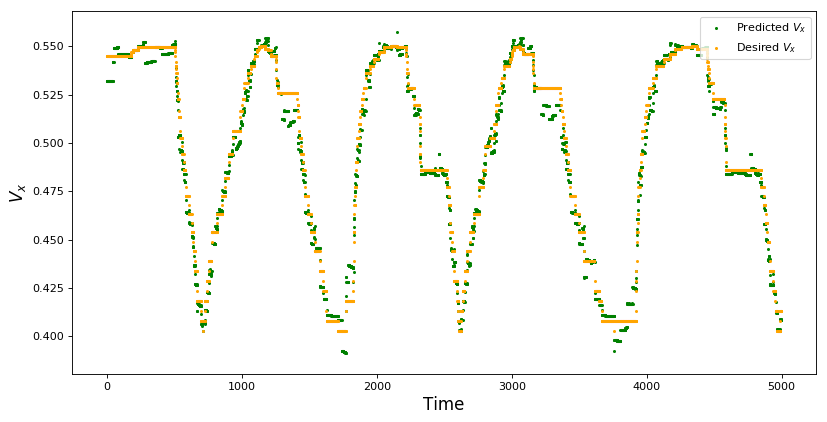

In [10]:
time = [i for i in range(num_test)]
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time, pred[:, 0], s=3, color='g', label="Predicted $V_x$")
pyplot.scatter(time, test_y[:, 0], s=3, color='orange', label='Desired $V_x$')
pyplot.ylabel("$V_x$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper right')
pyplot.show()

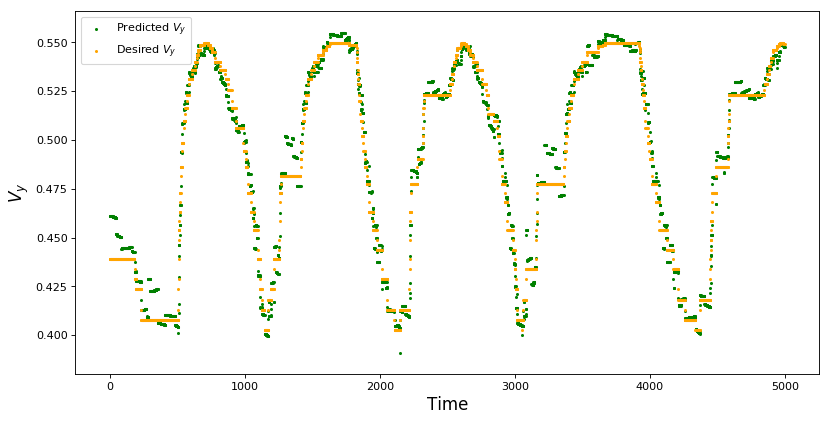

In [11]:
fig=pyplot.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
pyplot.scatter(time, pred[:, 1], s=3, color='g', label="Predicted $V_y$")
pyplot.scatter(time, test_y[:, 1], s=3, color='orange', label='Desired $V_y$')
pyplot.ylabel("$V_y$", fontsize=15)
pyplot.xlabel("Time", fontsize=15)
pyplot.legend(loc='upper left')
pyplot.show()